# **<span style="color: black;">STAT 201 Project Final Report - Group 38</span>** 
##### **-- by Pushya Jain, Jingyuan Liu, Ty Stevenson & Bowen Tian**

## Introduction

With the rise of unprovoked stranger attacks and safety concerns for Vancouverites, we will seek to better understand the relation of criminal activity and time of day. In our STAT201 group project, we propose the following question of interest: **How does the proportion of violent crimes vary between daytime and nighttime?** The data is provided by the Vancouver Police Department on the open source “geodash” website. We will be using the data from 2020 to 2022 for all neighborhoods within the Vancouver municipal proper. The goal of this study is to understand if daytime and nighttime hours tend to harbour different types of crimes, which may be useful in further inferences about the motivations behind such crimes (CS Wisdom et H. Torch). These trends can also assist in predicting criminal activity and developing preventive and punitive methods to reduce crime, and understand the underlying social problems conducive to crimes (University of Minnesota).

## Methods and results

**<span style="color: red;">Load all necessary packages into R and set the seed. Run this cell before continuing.</span>**

In [124]:
library(tidyverse)
library(tidymodels)
library(gridExtra)
library(repr)
library(cowplot)
library(broom)
library(digest)
library(infer)
library(gridExtra)
set.seed(38)
options(repr.matrix.max.rows = 8)
options(repr.plot.width = 7, repr.plot.height = 6) 

### Wrangling and Cleaning Data

We first read the raw data from the web using its url and filter years from 2020 onwards. We store the population raw dataset as `vancouver_crime_raw_data`. We decide to only use the years from 2020 onwards beacuse it takes too long to run the wrangling and cleaning cells otherwise.

In [125]:
url <- "https://raw.githubusercontent.com/PUSH-YA/stat-201-2022w1-group-38/main/crimedata_csv_AllNeighbourhoods_AllYears.csv"
vancouver_crime_raw_data <- read_csv(url) %>% filter(YEAR %in% c(2020, 2021, 2022))
head(vancouver_crime_raw_data)

Rows: 842492 Columns: 10
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): TYPE, HUNDRED_BLOCK, NEIGHBOURHOOD
dbl (7): YEAR, MONTH, DAY, HOUR, MINUTE, X, Y

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


TYPE,YEAR,MONTH,DAY,HOUR,MINUTE,HUNDRED_BLOCK,NEIGHBOURHOOD,X,Y
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>
Theft from Vehicle,2022,8,14,17,0,1XX W HASTINGS ST,Central Business District,492029.3,5458866
Theft from Vehicle,2020,1,27,17,50,1XX W HASTINGS ST,Central Business District,492091.1,5458840
Theft from Vehicle,2022,4,16,9,58,1XX W HASTINGS ST,Central Business District,492101.0,5458837
Theft from Vehicle,2020,2,8,20,0,1XX W HASTINGS ST,Central Business District,492103.9,5458836
Theft from Vehicle,2022,6,16,13,0,1XX W HASTINGS ST,Central Business District,492107.4,5458835
Theft from Vehicle,2022,4,19,19,0,1XX W HASTINGS ST,Central Business District,492113.5,5458843


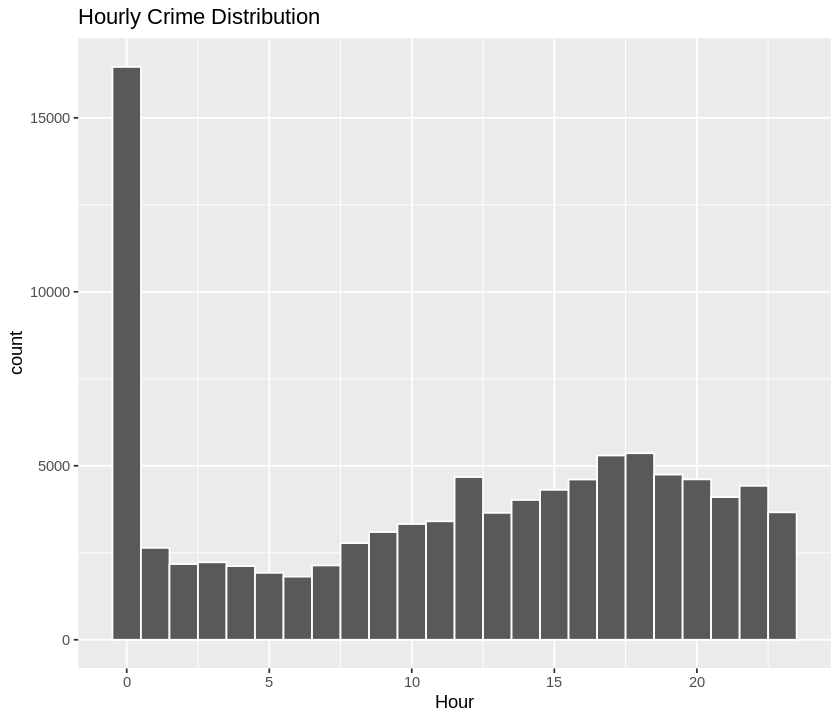

In [126]:
ggplot(vancouver_crime_raw_data) +
    geom_histogram(aes(x = HOUR), bins = 24, color = "White") +
    ggtitle("Hourly Crime Distribution") +
    xlab("Hour")

Remove all invalid rows at midnight.

In [127]:
# Filter out noon and midnight
vancouver_crime_filtered <- vancouver_crime_raw_data %>%
    mutate(TIME = HOUR * 60 + MINUTE) %>%
    filter(TIME != 0 & TIME != 720)

In our preliminary and exploratory analysis, we downloaded the dataset as a csv file and read it into Jupyter. We immediately noticed that there are spikes in the distribution around 00:00 and 12:00 (midnight and noon). We assumed this to be an artifact of estimating crime time in instances where the precise time is unknown (ex, if a crime occurred during the night, but was not found out till during the morning, officers may have reported that the crime occurred at midnight). To counteract this problem, we used a histogram to bin the dataset by the hour and removed values at midnight. This may cause the unintended effect of removing useful data such as the total number of crimes proportion. However, as we are comparing the two groups by daytime and nighttime, it should have little effect on the proportions calculated. We also use the more recent data from 2020 onwards. The histogram in question are shown below:

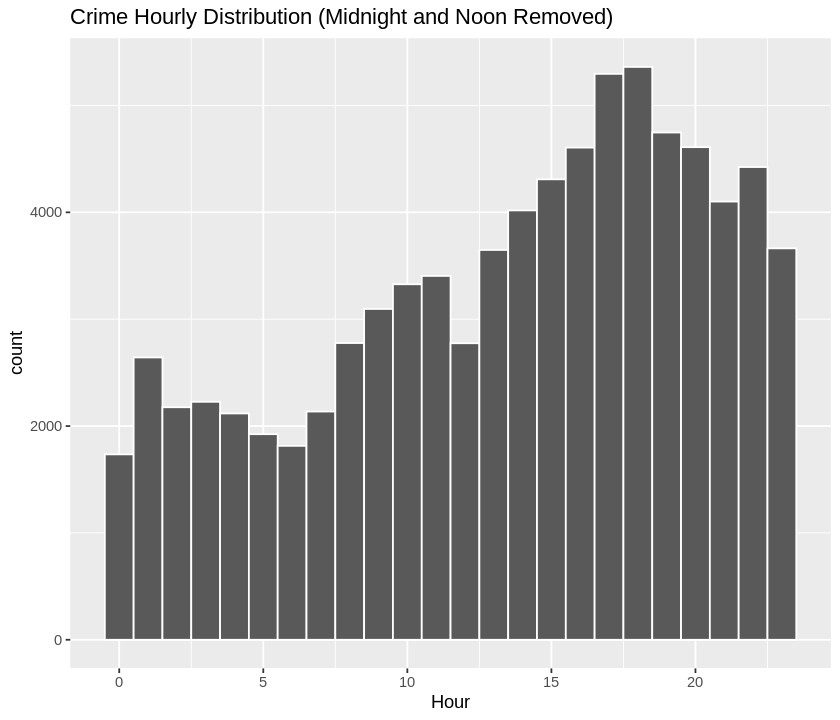

In [128]:
# Plot filtered data
ggplot(vancouver_crime_filtered) +
    geom_histogram(aes(x = HOUR), bins = 24, color = "White") +
    ggtitle("Crime Hourly Distribution (Midnight and Noon Removed)") +
    xlab("Hour")

In [129]:
# Create new column for crime violence
vancouver_crime_filtered_violence <- vancouver_crime_filtered %>%
    mutate(IS_VIOLENT = case_when(TYPE == "Vehicle Collision or Pedestrian Struck (with Injury)" ~ TRUE, 
                                   TYPE == "Vehicle Collision or Pedestrian Struck (with Fatality)" ~ TRUE, 
                                   TYPE == "Break and Enter Commercial" ~ TRUE, 
                                   TYPE == "Break and Enter Residential/Other" ~ TRUE, 
                                   TYPE == "Mischief" ~ FALSE, 
                                   TYPE == "Other Theft" ~ FALSE, 
                                   TYPE == "Theft from Vehicle" ~ FALSE, 
                                   TYPE == "Theft of Vehicle" ~ FALSE, 
                                   TYPE == "Theft of Bicycle" ~ FALSE))

In [130]:
# Determine whether daytime or nighttime in new column
vancouver_crime_filtered_violence_time <- vancouver_crime_filtered_violence %>%
    mutate(IS_DAYTIME = case_when(TIME < 361 ~ FALSE, 360 < TIME & TIME < 1081 ~ TRUE, TIME > 1080 ~ FALSE))

After classifying crime type as either violent or non-violent, and daytime or nighttime, we select only the rows of interest for our statistical analysis, and we store this neat population dataset as `vancouver_crime_clean_final`. The `TIME` column just represents the time of the crime in a day **in minutes**. For example, if the crime happens at 11:59, then the time should be 719 and if the crime happens at 23:59, then the time should be 1439.

In [131]:
vancouver_crime_clean_final <- vancouver_crime_filtered_violence_time %>%
    select(c("TIME", "IS_VIOLENT", "IS_DAYTIME"))
head(vancouver_crime_clean_final)

TIME,IS_VIOLENT,IS_DAYTIME
<dbl>,<lgl>,<lgl>
1020,FALSE,TRUE
1070,FALSE,TRUE
598,FALSE,TRUE
1200,FALSE,FALSE
780,FALSE,TRUE
1140,FALSE,FALSE


### Hypothesis Testing (Bootstrapping-simulated Method)

We first state the null hypothesis and the alternative hypothesis for this test.\
$H_0: p_{\text{nighttime violent crime}} = p_{\text{daytime violent crime}}$\
$H_a: p_{\text{nighttime violent crime}} \neq p_{\text{daytime violent crime}}$\
\
We then need to state the significance level for this test.\
We decide to use the default significance level $\alpha = 0.05$.

To perform the hypothesis test with the bootstrapping-simulated method using the `infer` package, let's first use the `rep_sample_n` function to obtain a random sample of size 1000 called `test_bs_sample` from the tidy population dataset `vancouver_crime_clean_final`. We already set the seed at the beginning of this notebook.

In [132]:
# take a random sample from the population 
set.seed(38)
test_bs_sample <- vancouver_crime_clean_final %>%
    rep_sample_n(size = 1000) %>% ungroup() %>%
    select (c(IS_VIOLENT, IS_DAYTIME))
head(test_bs_sample)

IS_VIOLENT,IS_DAYTIME
<lgl>,<lgl>
FALSE,TRUE
TRUE,TRUE
FALSE,FALSE
FALSE,TRUE
FALSE,FALSE
FALSE,TRUE


Now we use the workflow in the `infer` package to conduct our simulated hypothesis. Assuming the null hypothesis is true, we generate 2000 replicates. And then we calculate the appropriate summary statistic for each of the 2000 samples under the assumption that $H_0$ is true. This forms the null distribution, and we stroe it as `null_distribution`.

In [133]:
# generate the null distribution
set.seed(38)
null_distribution <- test_bs_sample %>% 
  specify(formula = IS_VIOLENT ~ IS_DAYTIME, success = "TRUE") %>% 
  hypothesize(null = "independence") %>% 
  generate(reps = 2000, type = "permute") %>% 
  calculate(stat = "diff in props", order = c("FALSE", "TRUE"))

head(null_distribution)

replicate,stat
<int>,<dbl>
1,0.0558811722
2,0.0077077479
3,-0.0123645122
4,-0.0003211562
5,-0.0163789643
6,-0.0043356082


Then we need to calculate the observed differnece in proportions based on the sample `test_bs_sample` we just obtained. This is our observed statistics $\hat p_{\text{nighttime violent crime}}-\hat p_{\text{daytime violent crime}}$. We store this observed difference in proportions as `obs_diff_prop`.

In [134]:
# calculate the observed difference in proportions from the sample
obs_diff_prop <- test_bs_sample %>% 
    specify(formula = IS_VIOLENT ~ IS_DAYTIME, success = "TRUE") %>%
    calculate(stat = "diff in props", order = c("FALSE", "TRUE"))
obs_diff_prop

stat
<dbl>
0.03982336


Now, we can visualize our null distribution `null_distribution` by the `visualize()` function in the `infer` package. We will also shade the area that is as extreme or more extreme than our observed statistics by the `shade_p_value()` function in the `infer` package. Since our alternative hypothesis is $H_a: p_{\text{nighttime violent crime}} \neq p_{\text{daytime violent crime}}$\, we need to shade both tails. We will store this null distribution plot as `null_distribution_plot`.

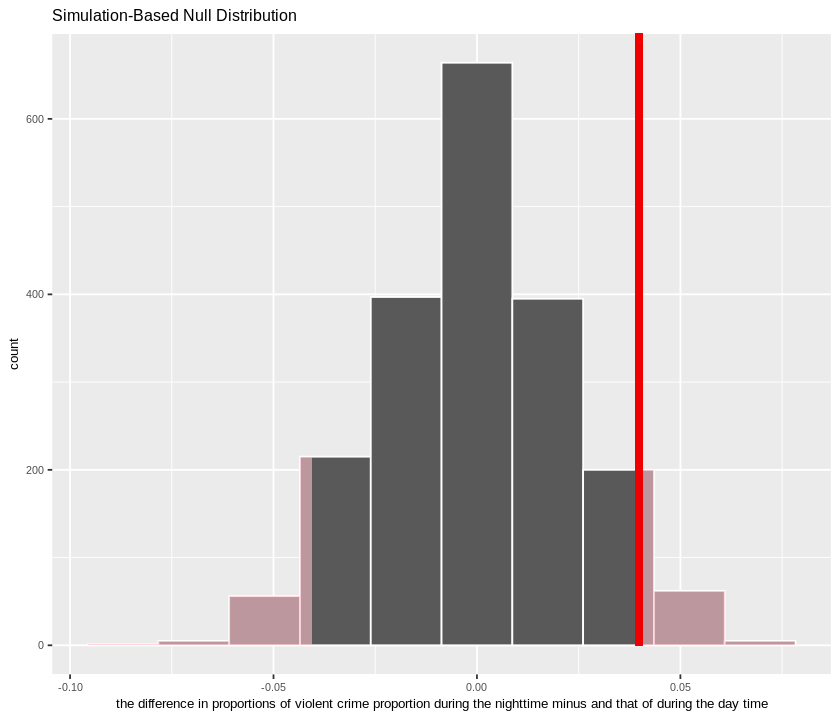

In [135]:
# visualize the null distribution and shade the p-value
null_distribution_plot <- visualize(null_distribution, bins = 10) + 
    shade_p_value(obs_stat = obs_diff_prop, direction = "both")+
    xlab("the difference in proportions of violent crime proportion during the nighttime minus and that of during the day time")+
    theme(text = element_text(size=8))
null_distribution_plot 

We can then calculate the p-value by the `get_p_value()` function in the `infer` package. We will use this p-value for further comparision. We store this value as `p_value`

In [136]:
# calculate the p-value
p_value <- null_distribution %>%
    get_p_value(obs_stat = obs_diff_prop, direction = "both")
p_value

p_value
<dbl>
0.097


Since the p-value above is larger than the significance level $\alpha =0.05$, which means that we do not have significant evidence to support the alternative hypothesis so we fail to reject the null hypothesis. Therefore, we can conclude that our evidence is not significant enough to support the alternative hypothesis that the true proportion of violent crime during the nighttime is different from the true proportion of violent crime during the daytime. We fail to reject the null hypothesis that the true proportions of violent crime during the nighttime and daytime is the same. We might need further investigation into it.

Alternatively, we can also use the `infer` package workflow to obtain the bootstrapping distribution for the sample `test_bs_sample` and calculate the confidence interval for the true difference in proportions based on `test_bs_sample`. We will use a 95% confidence level for the confidence interval because it corresponds to the 0.05 significance level for a two-tailed hypothesis test. We will store the confidence interval as `ci_diff_in_props` and the visualization of the bootstraping distribution and the confidence interval as `bs_distribution_and_ci`.

lower_ci,upper_ci
<dbl>,<dbl>
-0.006373632,0.08570752


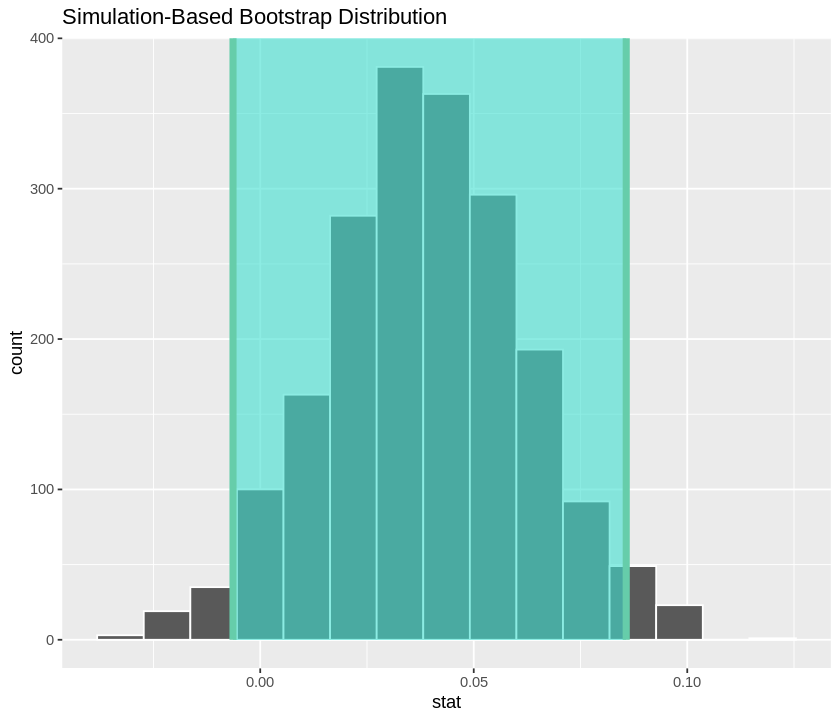

In [137]:
# calculate the confidence interval
set.seed(38)
ci_diff_in_props <- test_bs_sample %>%
    specify(formula = IS_VIOLENT ~ IS_DAYTIME, success = "TRUE") %>% 
    generate(reps = 2000, type = "bootstrap") %>%
    calculate(stat = "diff in props", order = c("FALSE", "TRUE")) %>%
    get_confidence_interval(level = 0.95, type = "percentile")
ci_diff_in_props

bs_distribution_and_ci <- test_bs_sample %>%
    specify(formula = IS_VIOLENT ~ IS_DAYTIME, success = "TRUE") %>% 
    generate(reps = 2000, type = "bootstrap") %>%
    calculate(stat = "diff in props", order = c("FALSE", "TRUE")) %>%
    visualize()+shade_confidence_interval(endpoints = ci_diff_in_props)
bs_distribution_and_ci

As you can see, the confidence interval for the true difference in proportions based on `test_bs_sample` does contain the difference in proportions under the null hypothesis which is $0$. Because the 95% confidence level corresponds to the 0.05 significance level for a two-tailed hypothesis test, this also suggests that we fail to reject $H_0$ under the sample we collected.

### Theory-based Hypothesis Testing (asymptotic Method)

The theory based hypothesis testing will be conducting by taking the 2 sample proportion test statistics of the vancouver crime data. This will be done by first dividing the `test_bs_sample` (the sample from the previous method) into its 2 groups: daytime and nighttime. These will be called `nighttime_vanvouver_crime_sample` and `daytime_vancouver_crime_sample`. These groups will be then be used to calculate certain parameters such as the number of successes stored in `sum1` and `sum2`, the number of observations in each group stored in `n1` and `n2` and these would be used to calculate the 2 group's proportion which would be stored in `prop1` and `prop2`. We store the theory-based observed difference in proportions as `theory_obs_diff_prop`. These parameters will then be used to calculate the p-value for the theory based 2-sample-proportions-statistic and the theory based confidence interval.

$H_0: p_{\text{nighttime violent crime}} = p_{\text{daytime violent crime}}$\
$H_a: p_{\text{nighttime violent crime}} \neq p_{\text{daytime violent crime}}$

The theory based 2-sample-proportion-statistic is calculated using the following formula: 
$$
Z = \frac{\hat{p}_1 - \hat{p}_2}{\sqrt{\hat{p}(1-\hat{p})\left(\frac{1}{n_1} + \frac{1}{n_2}\right)}}
$$
where $\hat{p}_1$ and $\hat{p}_2$ are the sample proportions in groups 1 and 2, respectively; $n$ is the sample size; and $\hat{p}$ is the pooled proportion, given by: 

$$\hat{p} = \frac{n_1\hat{p}_1+n_2\hat{p}_2}{n_1+n_2}$$
The test statistic will then be used to calculate the 2-sided p-value.

This is all done using `prop.test` with the two group's number of successes and their sizes used as parameters. The confidence level is set to 95% as $\alpha$ is 0.05 and the test is two sided.

In [138]:
# separating the sample from the bootstrapping method into daytime and nighttime samples.
set.seed(38)
nighttime_vanvouver_crime_sample <- test_bs_sample %>% filter(!IS_DAYTIME) %>% 
    select(IS_VIOLENT) 
daytime_vancouver_crime_sample <- test_bs_sample %>% filter(IS_DAYTIME) %>% 
    select(IS_VIOLENT) 

# calculating observed statistics for the 2 groups
sum1 <- sum(nighttime_vanvouver_crime_sample$IS_VIOLENT)
sum2 <- sum(daytime_vancouver_crime_sample$IS_VIOLENT)

n1 <- nrow(nighttime_vanvouver_crime_sample)
n2 <- nrow(daytime_vancouver_crime_sample)

prop1 <- sum1/n1
prop2 <- sum2/n2

# calculate the observed difference in proportions 
theory_obs_diff_prop <- prop1 - prop2
theory_obs_diff_prop

#calculating p-value using prop.test()
theory_hypothesis_test <-  tidy(
                    prop.test(x = c(sum1,sum2), # an array with the number of successes in each sample
                      n = c(n1, n2), # an array with the size of each sample
                    conf.level = 0.95,
                    correct = FALSE,
                    alternative = "two.sided")) 
theory_hypothesis_test

theory_p_val <- theory_hypothesis_test %>% select (p.value)
theory_p_val

[1] 0.03982336

estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
0.1851064,0.145283,2.881373,0.08960958,1,-0.006360081,0.08600681,2-sample test for equality of proportions without continuity correction,two.sided


p.value
<dbl>
0.08960958


The 2-sample-proportion-test yields a p-value that is larger than the significance level $\alpha =0.05$, which means that we do not have significant evidence to support the alternative hypothesis so we fail to reject the null hypothesis. Therefore, we can conclude that our evidence from the two samples is not significant enough to support the alternative hypothesis that the true proportion of violent crime during the nighttime is different from the true proportion of violent crime during the daytime. We fail to reject the null hypothesis that the true proportions of violent crime during the nighttime and daytime is the same. We might need further investigation into it.

Next a 95% confidence interval will be calculated for the difference in proportion of day and night time violent crimes manually to check if it mapps to the same confidence interval obtained by the `prop.test()` function above. The confidence interval will be calculated by assumeing CLT (central limit theorem) assuming each observation is independent, the samples are random, and the sample is large enoough (with enough successes and failures), to assume normality of the sampling distribution. We have checked that our samples meet all requirements for CLT. The following normality is assumed:

$\hat{p}_{diff}$ ~ $N(\hat{p}_1 - \hat{p}_2, \sqrt{\frac{\hat{p}_1(1-\hat{p}_1)}{n_1} - \frac{\hat{p}_2(1-\hat{p}_2)}{n_2}})$

This normal distribution is used to calculate the confidence interval based on the general formula of $\mu \pm z^* \cdot SE$ where the z-score is based on the confidence interval we want, 95% in our case.

In [139]:
# calculating ci using CLT
std_error = sqrt(prop1 * (1-prop1)/n1 + prop2*(1-prop2)/n2 )

theory_based_ci <- tibble(lower_ci = theory_obs_diff_prop - qnorm(0.975) * std_error,
                upper_ci = theory_obs_diff_prop + qnorm(0.975)*std_error)
theory_based_ci

lower_ci,upper_ci
<dbl>,<dbl>
-0.006360081,0.08600681


Based, on the calculation above, there is a 95% chance that the difference in the proportion lies between -0.00636 and 0.08601, which is exactly the same as the confidence interval obtained by the `prop.test()` function above. Since this confidence interval does contain the difference in proportions under the null hypothesis which is $0$. Because the 95% confidence level corresponds to the 0.05 significance level for a two-tailed hypothesis test, this also suggests that we fail to reject $H_0$ under the sample we collected.

## Discussion

- interpret the results in the above section
- discuess whether your results were the same as you expected
- discuss future questions /research this study could lead to

## References

- VPD OPEN DATA. (n.d.). “Vancouver Police Department Crime Data.”, Retrieved from https://geodash.vpd.ca/opendata/ and https://opendata.vancouver.ca/pages/home/
-  Chester Ismay and Albert Y. Kim (2022e, October 28). Statistical Inference via Data Science. https://moderndive.com/
- CS Widom; H Toch. “Contribution of Psychology to Criminal Justice Education.” CONTRIBUTION OF PSYCHOLOGY TO CRIMINAL JUSTICE EDUCATION | Office of Justice Programs, Retrieved from https://www.ojp.gov/ncjrs/virtual-library/abstracts/contribution-psychology-criminal-justice-education
- University of Minnesota. “8.2 Types of Crime.” Social Problems, University of Minnesota Libraries Publishing Edition, 2015. This Edition Adapted from a Work Originally Produced in 2010 by a Publisher Who Has Requested That It Not Receive Attribution., 25 Mar. 2016, Retrieved from https://open.lib.umn.edu/socialproblems/chapter/8-2-types-of-crime/ 